# Mask R-CNN - part 1

See:
 - https://medium.com/@ageitgey/snagging-parking-spaces-with-mask-r-cnn-and-python-955f2231c400
 - https://github.com/matterport/Mask_RCNN
 - https://towardsdatascience.com/building-a-custom-mask-rcnn-model-with-tensorflow-object-detection-952f5b0c7ab4
 - https://arxiv.org/abs/1703.06870
 - https://www.youtube.com/watch?v=UdZnhZrM2vQ&t=111s

Before you start:
 - Clone Mask_RCNN, install dependencies https://github.com/matterport/Mask_RCNN
 - Download weights of COCO model https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
 - Download COCO dataset from http://cocodataset.org/#download or at least the adnotations https://vision.ece.vt.edu/mscoco/coco/annotations/instances_train-val2014.zip

## Tensorflow test

In [1]:
import tensorflow

tensorflow.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

## Paths

Remember to change to your own...

In [2]:
import os

ROOT_DIR = os.path.abspath("../../varia/Mask_RCNN/")
MODEL_DIR = os.path.abspath("/data/coco/")
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")

## Libraries

In [3]:
import sys
import random
import math

import numpy as np
import skimage.io

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
"""Import Mask R-CNN."""
sys.path.append(ROOT_DIR)
import mrcnn.utils
import mrcnn.model
import mrcnn.visualize

Using TensorFlow backend.


## Configuration

In [5]:
"""Load the configuration file for the MS-COCO model."""
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))
import coco


class InferenceConfig(coco.CocoConfig):
    """Owerwrite the batch size.
    
    Batch size = GPU_COUNT * IMAGES_PER_GPU
    For our needs, we need batch size = 1
    """
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5

    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
"""Create a model object and load the weights."""
model = mrcnn.model.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [7]:
"""Check class numbers."""
dataset = coco.CocoDataset()
dataset.load_coco(MODEL_DIR, "train")
dataset.prepare()

for i, name in enumerate(dataset.class_names):
    print(i, name)

loading annotations into memory...
Done (t=9.35s)
creating index...
index created!
0 BG
1 person
2 bicycle
3 car
4 motorcycle
5 airplane
6 bus
7 train
8 truck
9 boat
10 traffic light
11 fire hydrant
12 stop sign
13 parking meter
14 bench
15 bird
16 cat
17 dog
18 horse
19 sheep
20 cow
21 elephant
22 bear
23 zebra
24 giraffe
25 backpack
26 umbrella
27 handbag
28 tie
29 suitcase
30 frisbee
31 skis
32 snowboard
33 sports ball
34 kite
35 baseball bat
36 baseball glove
37 skateboard
38 surfboard
39 tennis racket
40 bottle
41 wine glass
42 cup
43 fork
44 knife
45 spoon
46 bowl
47 banana
48 apple
49 sandwich
50 orange
51 broccoli
52 carrot
53 hot dog
54 pizza
55 donut
56 cake
57 chair
58 couch
59 potted plant
60 bed
61 dining table
62 toilet
63 tv
64 laptop
65 mouse
66 remote
67 keyboard
68 cell phone
69 microwave
70 oven
71 toaster
72 sink
73 refrigerator
74 book
75 clock
76 vase
77 scissors
78 teddy bear
79 hair drier
80 toothbrush


In [8]:
dataset.class_names.index('car')

3

## Big parking lot example

In [9]:
"""Load a image."""
IMAGE = os.path.abspath("../resources/images/parking_lot_big.jpeg")
image = skimage.io.imread(IMAGE)
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (973, 1765, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1765.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


## Count number of cars

In [11]:
"""Return how many cars, buses and trucks we detected."""
r = results[0]
n_cars = len([i for i in r['class_ids'] if i in (3, 6, 8)])
n_cars

96

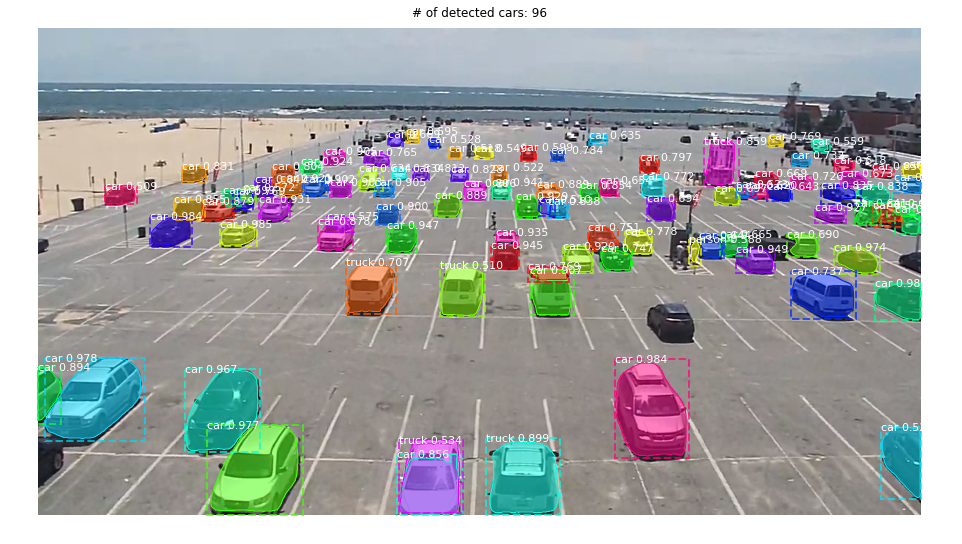

In [12]:
# Visualize results
mrcnn.visualize.display_instances(
    image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'],
    title='# of detected cars: {}'.format(n_cars))